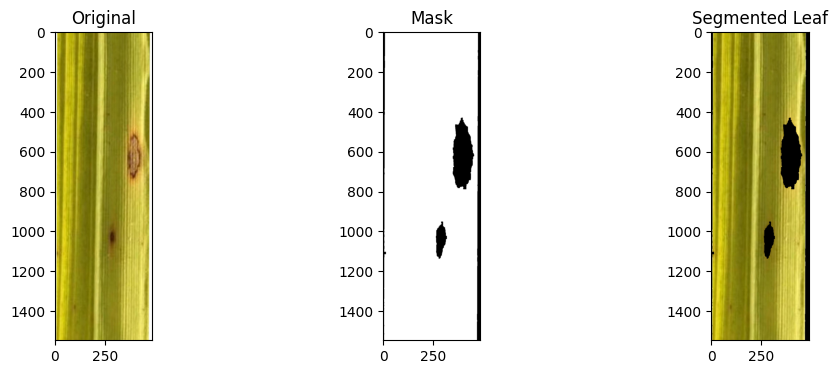

In [5]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def segment_leaf(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    lower_green = np.array([25, 40, 40]) 
    upper_green = np.array([90, 255, 255])
    mask = cv2.inRange(hsv, lower_green, upper_green)

    kernel = np.ones((5, 5), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)  
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)  

    segmented = cv2.bitwise_and(img, img, mask=mask)

    return img, mask, segmented
#13,109,61
image_path = r"C:\Users\Poornima\Documents\train\brown_spot\brown_spot109.jpg"
original, mask, segmented = segment_leaf(image_path)

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1), plt.imshow(original), plt.title("Original")
plt.subplot(1, 3, 2), plt.imshow(mask, cmap='gray'), plt.title("Mask")
plt.subplot(1, 3, 3), plt.imshow(segmented), plt.title("Segmented Leaf")
plt.show()

In [3]:
import tensorflow as tf
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
import numpy as np

In [ ]:
def build_inception_resnetv2(input_shape=(299, 299, 3)):
    base_model = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False  
    x = GlobalAveragePooling2D()(base_model.output)
    inception_output = Dense(512, activation='relu')(x)
    return Model(base_model.input, inception_output, name="InceptionResNetV2_FeatureExtractor")


In [7]:
inception_model = build_inception_resnetv2()

In [11]:
inception_model.save("inception_model.keras")

In [2]:
import tensorflow as tf
from tensorflow.keras.applications.inception_resnet_v2 import preprocess_input
from tensorflow.keras.preprocessing import image
import numpy as np

model = tf.keras.models.load_model("inception_model.keras")


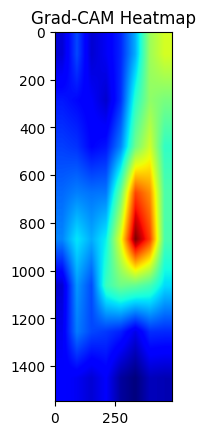

(<matplotlib.image.AxesImage at 0x2562416a6e0>,
 Text(0.5, 1.0, 'Grad-CAM Heatmap'),
 None)

In [6]:
def generate_gradcam(model, img_array, layer_name="conv_7b_ac"):
    img = cv2.resize(img_array, (299, 299))
    img = image.img_to_array(img)
    img = preprocess_input(img)
    img = np.expand_dims(img, axis=0)

    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, preds = grad_model(img)
        pred_idx = tf.argmax(preds[0])
        loss = preds[:, pred_idx]

    grads = tape.gradient(loss, conv_outputs)[0]

    weights = tf.reduce_mean(grads, axis=(0, 1))
    heatmap = tf.reduce_sum(conv_outputs * weights, axis=-1)
    heatmap = tf.squeeze(heatmap).numpy()
    heatmap = np.maximum(heatmap, 0)  
    heatmap /= np.max(heatmap)  

    heatmap = cv2.resize(heatmap, (img_array.shape[1], img_array.shape[0]))
    return heatmap

heatmap = generate_gradcam(model, segmented)
plt.imshow(heatmap, cmap="jet"), plt.title("Grad-CAM Heatmap"), plt.show()

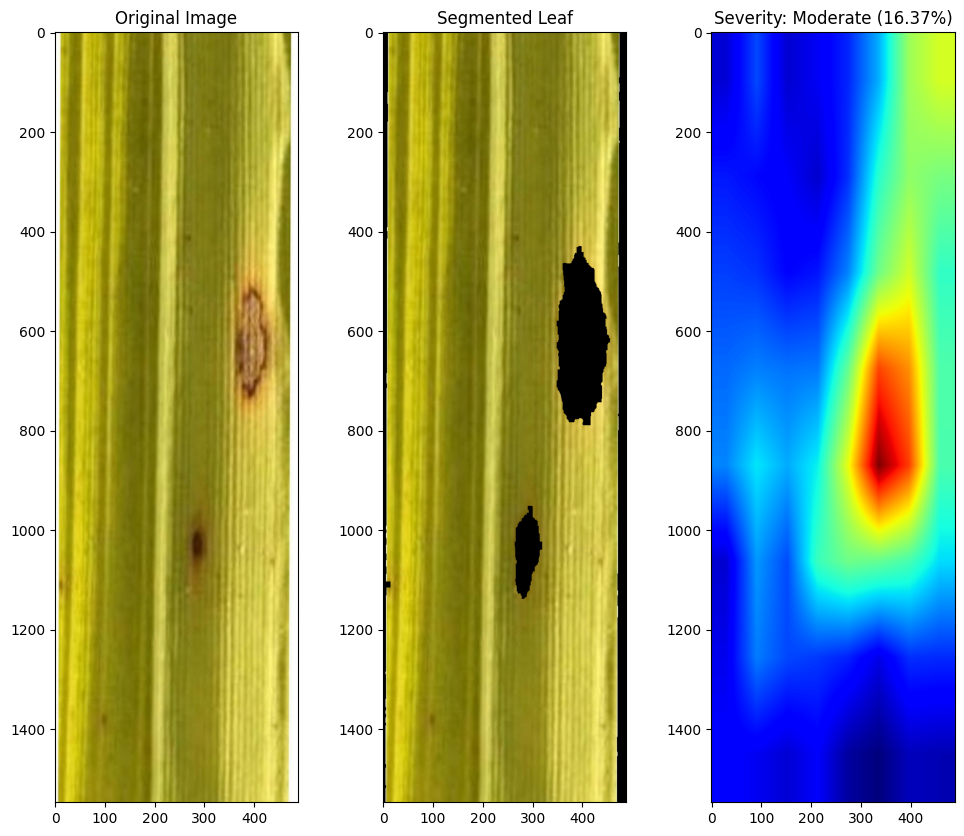

In [7]:
def estimate_severity(heatmap, mask, threshold=0.5):
    _, binary_heatmap = cv2.threshold(heatmap, threshold, 1, cv2.THRESH_BINARY)

    binary_heatmap = cv2.bitwise_and(binary_heatmap, binary_heatmap, mask=mask)

    total_leaf_pixels = np.sum(mask / 255)
    diseased_pixels = np.sum(binary_heatmap)
    severity_percent = (diseased_pixels / total_leaf_pixels) * 100

    # Classify severity
    if severity_percent < 10:
        severity_class = "Mild"
    elif severity_percent < 60:
        severity_class = "Moderate"
    else:
        severity_class = "Severe"

    return severity_percent, severity_class, binary_heatmap

severity_percent, severity_class, binary_heatmap = estimate_severity(heatmap, mask)

plt.figure(figsize=(12, 10))
plt.subplot(1, 3, 1), plt.imshow(original), plt.title("Original Image")
plt.subplot(1, 3, 2), plt.imshow(segmented), plt.title("Segmented Leaf")
plt.subplot(1, 3, 3), plt.imshow(heatmap, cmap="jet"), plt.title("Heatmap")
plt.title(f"Severity: {severity_class} ({severity_percent:.2f}%)")
plt.show()

In [13]:
import json

result = {
    "severity_percent": round(severity_percent, 2),
    "severity_class": severity_class
}

json_output = json.dumps(result)
print(json_output)


{"severity_percent": 7.43, "severity_class": "Mild"}
